In [1]:
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt 

## Up And Out Call Option

In [2]:
r = 0.02 
sigma = 0.3 
S0 = 100
K = 100
L = 110
T = 1

## <center> $ V_{t} = 1_{max[0, t] S_{t} \le B} [c(t, S_{t}) - w(t, S_{t})]$ </center>

## <center> $ w(t, x) = e^{-(r + \frac{\alpha^2}{2})(T - t)} [x \cdot H(\alpha + \sigma, 0, \frac{log\frac{K}{x}}{\sigma}, \frac{log\frac{b}{x}}{\sigma}) - K \cdot H(\alpha, 0, \frac{log\frac{K}{x}}{\sigma}, \frac{log\frac{b}{x}}{\sigma})]$ </center> 

## <center> $ c(t, x) = x \cdot N(d_{+}) - K e^{-rT} \cdot N(d_{-}) $ </center> 

In [3]:
alpha = (r - 0.5 * sigma**2) / sigma
alpha

-0.08333333333333333

In [4]:
k = np.log(K / S0) / sigma
k

0.0

In [5]:
b = np.log(L / S0) / sigma
b

0.3177005993477498

## <center> $ 0 \leq b \leq k $ </center>

## <center> $H_{s}(\alpha, 0, k, b) = E[1_{W_{s}\geq k} \cdot e^{\alpha W_{s}}] = e^{s \frac{\alpha^2}{2}} \cdot N(\frac{s\alpha - k}{\sqrt{s}}) $ </center>

In [6]:
def get_H1_Case_One(alpha, k, b, s):
    
    return np.exp(T * (alpha + sigma)**2 / 2) * norm.cdf((T * (alpha + sigma) - k) / np.sqrt(T))

In [7]:
H1 = get_H1_Case_One(alpha, k, b, T)
H1

0.5996777971260819

In [8]:
def get_H2_Case_One(alpha, k,b, T):
    
    return np.exp(T * alpha**2 / 2) * norm.cdf((T * alpha - k) / np.sqrt(T))

In [9]:
H2 = get_H2_Case_One(alpha, k, b, T)
H2

0.4684168752025011

## <center> $k \leq b$ </center> 

## <center> $H_{s}(\alpha, 0, k, b) = e^{s \frac{\alpha^2}{2}} \cdot (N(\frac{s\alpha - b}{\sqrt{s}}) + e^{2\alpha b} \cdot(N(\frac{-s\alpha-b}{\sqrt{s}}) - N(\frac{-s\alpha - 2b + k}{\sqrt{s}})) )$ </center>

In [10]:
def get_H1_Case_Two(alpha, k, b, s):
    
    E1 = np.exp(s * alpha**2 / 2)
    E2 = np.exp(2 * alpha * b)

    N1 = norm.cdf((s * alpha - b) / np.sqrt(s))
    N2 = norm.cdf((-s * alpha - b) / np.sqrt(s))
    N3 = norm.cdf((-s * alpha - 2 * b + k) / np.sqrt(s))

    H1 = E1 * (N1 + E2 * (N2 - N3))
    
    return H1

In [11]:
H1 = get_H1_Case_Two(alpha + sigma, k, b, T)
H1

0.5875265895642988

In [12]:
def get_H2_Case_Two(alpha, k, b, s):
    
    E1 = np.exp(s * alpha**2 / 2)
    E2 = np.exp(2 * alpha * b)

    N1 = norm.cdf((s * alpha - b) / np.sqrt(s))
    N2 = norm.cdf((-s * alpha - b) / np.sqrt(s))
    N3 = norm.cdf((-s * alpha - 2 * b + k) / np.sqrt(s))

    H2 = E1 * (N1 + E2 * (N2 - N3))
    
    return H2

In [13]:
H2 = get_H2_Case_Two(alpha, k, b, T)
H2

0.45665062637832576

In [14]:
def d1(S, K, T, r, sigma):
    
    return (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))

def d2(S, K, T, r, sigma):
    
    return d1(S, K, T, r, sigma) - sigma * np.sqrt(T)

def bs_call(S, K, T, r, sigma):
    
    return S * norm.cdf(d1(S, K, T, r, sigma)) - K * np.exp(-r * T) * norm.cdf(d2(S, K, T, r, sigma))

## Analytic Solution

In [15]:
alpha = (r - 0.5 * sigma**2) / sigma
w = np.exp(-(r + alpha**2 / 2) * (T)) * (S0 * H1 - K * H2)
w

12.783978580561701

In [16]:
c = bs_call(S0, K, T, r, sigma)
c

12.82158139269142

In [17]:
knockout = c - w
knockout

0.03760281212971961

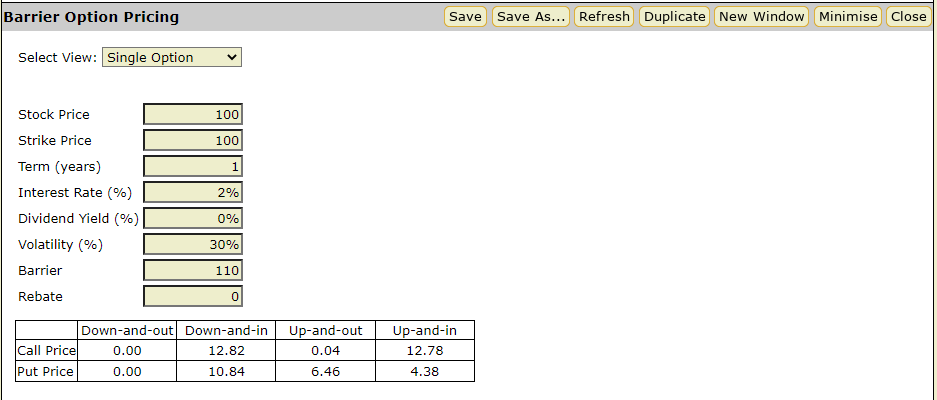

## Price Looks Correct !! 

## Matches Exotic Option Calculator

## -----------------------

## Option Time Series

## Generate a Path That Does Not Cross Border

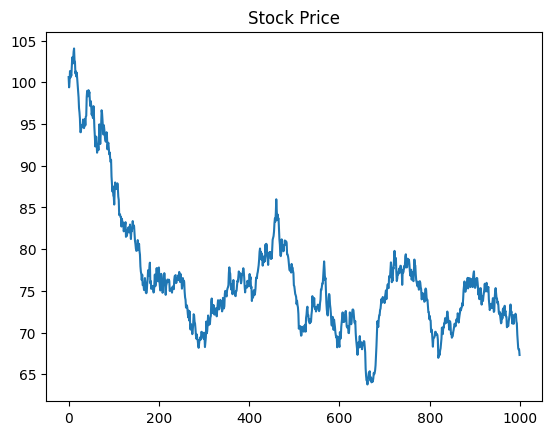

In [18]:
while True:

    N = 1000
    dt = 1 / N
    stock_process = np.zeros(N)
    rv = np.random.normal(0, 1, N)

    B = np.cumsum(rv * np.sqrt(dt))
    stock_process = 100 * np.exp((r - 0.5 * sigma**2) * dt + sigma * B)

    if np.max(stock_process) < L:
        break
    
plt.plot(stock_process)
plt.title("Stock Price")
plt.show()

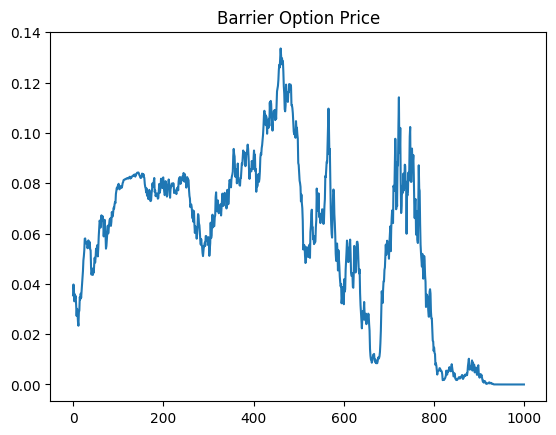

In [19]:
tau = np.linspace(0, 1 - 1e-5, N)

epsilon = 1e-3

CN = np.zeros(N)
C1 = np.zeros(N)

VN = np.zeros(N)
V1 = np.zeros(N)

KN = np.zeros(N)
K1 = np.zeros(N)

index = 0
for t in tau:
                     
    T = 1 - t
    
    k = np.log(K / stock_process[index]) / sigma
    b = np.log(L / stock_process[index]) / sigma

    if k <= b:
                
        H1 = get_H1_Case_Two(alpha + sigma, k, b, T)
        H2 = get_H2_Case_Two(alpha, k, b, T)
        
        CN[index] = bs_call(stock_process[index], K, T, r, sigma)
        VN[index] = np.exp(-(r + alpha**2 / 2) * (T)) * (stock_process[index] * H1 - K * H2)    
        KN[index] = CN[index] - VN[index]
        
        k = np.log(K / (stock_process[index] + epsilon)) / sigma
        b = np.log(L / (stock_process[index] + epsilon)) / sigma
        
        H1 = get_H1_Case_Two(alpha + sigma, k, b, T)
        H2 = get_H2_Case_Two(alpha, k, b, T)
    
        C1[index] = bs_call(stock_process[index] + epsilon, K, T, r, sigma)
        V1[index] = np.exp(-(r + alpha**2 / 2) * (T)) * ((stock_process[index] + epsilon) * H1 - K * H2)    
        K1[index] = C1[index] - V1[index]
        
    else: 
        
        CN[index] = bs_call(stock_process[index], K, T, r, sigma)
        VN[index] = np.exp(-(r + alpha**2 / 2) * (T)) * (stock_process[index] * H1 - K * H2)    
        KN[index] = CN[index] - VN[index]
        
        k = np.log(K / (stock_process[index] + epsilon)) / sigma
        b = np.log(L / (stock_process[index] + epsilon)) / sigma       
        
        H1 = get_H1_Case_One(alpha + sigma, k, b, T)
        H2 = get_H2_Case_One(alpha, k, b, T)
    
        C1[index] = bs_call(stock_process[index] + epsilon, K, T, r, sigma)
        V1[index] = np.exp(-(r + alpha**2 / 2) * (T)) * ((stock_process[index] + epsilon) * H1 - K * H2)    
        K1[index] = C1[index] - V1[index]
            
    index += 1
    
plt.plot(KN)
plt.title("Barrier Option Price")
plt.show()

1000


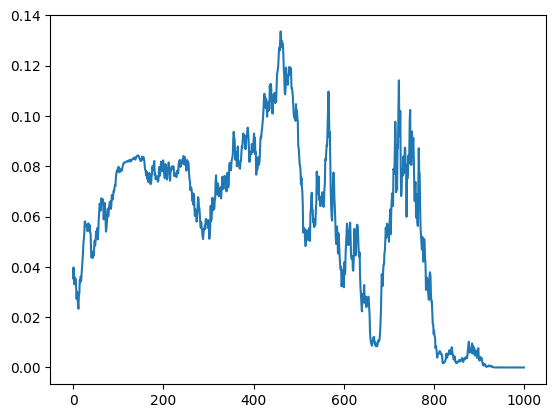

In [20]:
barrierCrossed = N

for i in range(N):
    
    if KN[i] < 0:
        
        KN[i:] = 0
        K1[i:] = 0
        
        barrierCrossed = i
        i = N

print(barrierCrossed)
plt.plot(KN)
plt.show()

## Finite Difference Method

In [21]:
print((C1[0] - CN[0]) / epsilon)
deltaC = (C1 - CN) / epsilon

print((V1[0] - VN[0]) / epsilon)
deltaV = (V1 - VN) / epsilon

0.5937533624305047
0.5972623840495572


In [22]:
print((K1[0] - KN[0]) / epsilon)
delta = (K1 - KN) / epsilon

-0.0035090216190525325


Initial Price:  0.035454234422015674
Initial Money Market:  0.38852401206204684


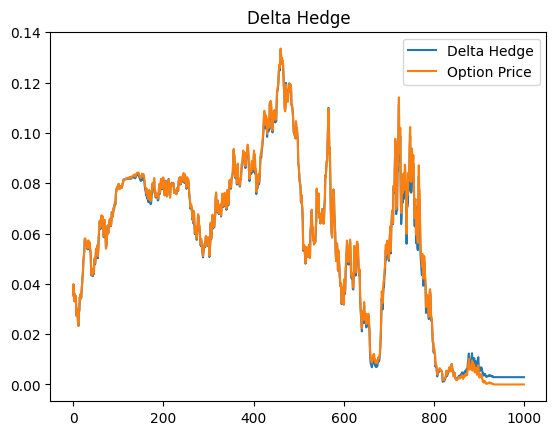

In [23]:
pi1 = np.zeros(N)
pi1[0] = KN[0]
print("Initial Price: ", pi1[0])

y = pi1[0] - (delta[0] * stock_process[0])
print("Initial Money Market: ", y)

for i in range(1, barrierCrossed):
    
    pi1[i] = (delta[i - 1] * stock_process[i]) + (y * np.exp(r * dt))
    y = pi1[i] - (delta[i] * stock_process[i])
    
plt.plot(pi1[:barrierCrossed], label = "Delta Hedge")
plt.plot(KN[:barrierCrossed], label = "Option Price")
plt.title("Delta Hedge")
plt.legend(loc = 'best')
plt.show()

In [24]:
print("Hedging Process: ", pi1[barrierCrossed - 1])
print("Option Price: ", KN[barrierCrossed - 1])

Hedging Process:  0.002903295032803892
Option Price:  0.0


## Option Time Series

## Generate a Path That Does Cross Border

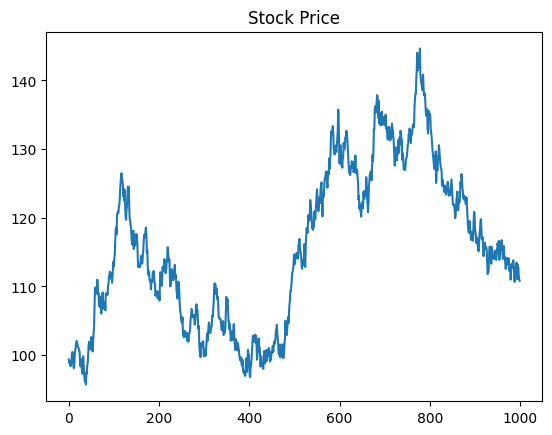

In [25]:
while True:

    N = 1000
    dt = 1 / N
    stock_process = np.zeros(N)
    rv = np.random.normal(0, 1, N)

    B = np.cumsum(rv * np.sqrt(dt))
    stock_process = 100 * np.exp((r - 0.5 * sigma**2) * dt + sigma * B)

    if np.max(stock_process) > L:
        break
    
plt.plot(stock_process)
plt.title("Stock Price")
plt.show()

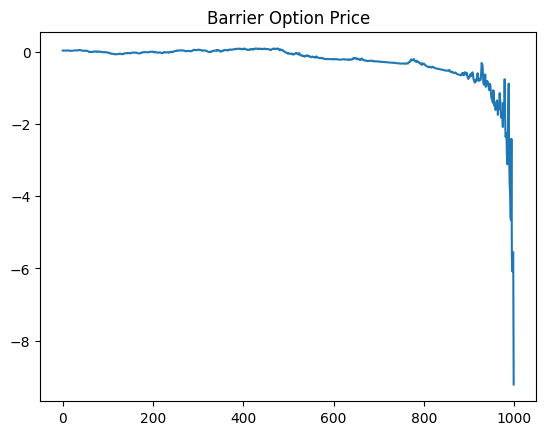

In [26]:
tau = np.linspace(0, 1 - 1e-5, N)

epsilon = 1e-3

CN = np.zeros(N)
C1 = np.zeros(N)

VN = np.zeros(N)
V1 = np.zeros(N)

KN = np.zeros(N)
K1 = np.zeros(N)

index = 0
for t in tau:
                     
    T = 1 - t
    
    k = np.log(K / stock_process[index]) / sigma
    b = np.log(L / stock_process[index]) / sigma

    if k <= b:
                
        H1 = get_H1_Case_Two(alpha + sigma, k, b, T)
        H2 = get_H2_Case_Two(alpha, k, b, T)
        
        CN[index] = bs_call(stock_process[index], K, T, r, sigma)
        VN[index] = np.exp(-(r + alpha**2 / 2) * (T)) * (stock_process[index] * H1 - K * H2)    
        KN[index] = CN[index] - VN[index]
        
        k = np.log(K / (stock_process[index] + epsilon)) / sigma
        b = np.log(L / (stock_process[index] + epsilon)) / sigma
        
        H1 = get_H1_Case_Two(alpha + sigma, k, b, T)
        H2 = get_H2_Case_Two(alpha, k, b, T)
    
        C1[index] = bs_call(stock_process[index] + epsilon, K, T, r, sigma)
        V1[index] = np.exp(-(r + alpha**2 / 2) * (T)) * ((stock_process[index] + epsilon) * H1 - K * H2)    
        K1[index] = C1[index] - V1[index]
        
    else: 
        
        CN[index] = bs_call(stock_process[index], K, T, r, sigma)
        VN[index] = np.exp(-(r + alpha**2 / 2) * (T)) * (stock_process[index] * H1 - K * H2)    
        KN[index] = CN[index] - VN[index]
        
        k = np.log(K / (stock_process[index] + epsilon)) / sigma
        b = np.log(L / (stock_process[index] + epsilon)) / sigma       
        
        H1 = get_H1_Case_One(alpha + sigma, k, b, T)
        H2 = get_H2_Case_One(alpha, k, b, T)
    
        C1[index] = bs_call(stock_process[index] + epsilon, K, T, r, sigma)
        V1[index] = np.exp(-(r + alpha**2 / 2) * (T)) * ((stock_process[index] + epsilon) * H1 - K * H2)    
        K1[index] = C1[index] - V1[index]
            
    index += 1
    
plt.plot(KN)
plt.title("Barrier Option Price")
plt.show()

63


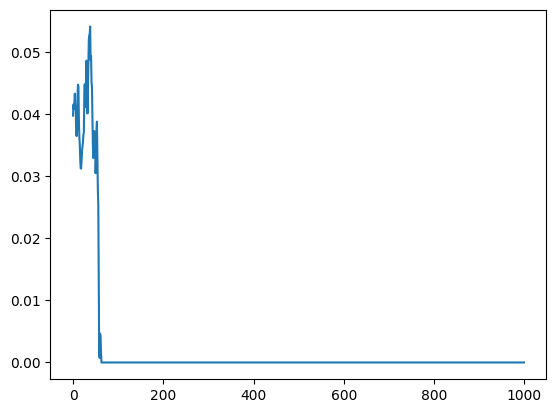

In [27]:
barrierCrossed = N

for i in range(N):
    
    if KN[i] < 0:
        
        KN[i:] = 0
        K1[i:] = 0
        
        barrierCrossed = i
        i = N

print(barrierCrossed)
plt.plot(KN)
plt.show()

In [28]:
print((C1[0] - CN[0]) / epsilon)
deltaC = (C1 - CN) / epsilon

print((V1[0] - VN[0]) / epsilon)
deltaV = (V1 - VN) / epsilon

0.5775904304741175
0.5809688305298266


In [29]:
print((K1[0] - KN[0]) / epsilon)
delta = (K1 - KN) / epsilon

-0.0033784000557091076


Initial Price:  0.0397411346450145
Initial Money Market:  0.3754644321087252


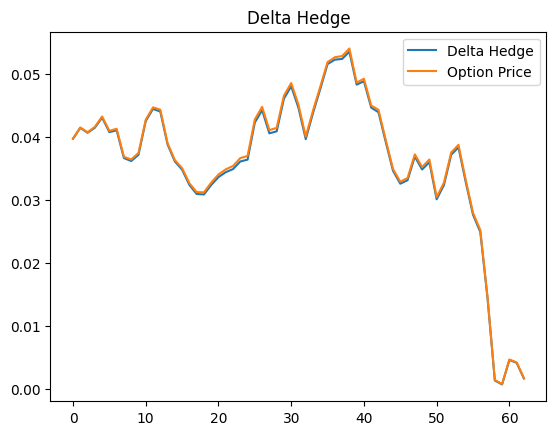

In [30]:
pi1 = np.zeros(N)
pi1[0] = KN[0]
print("Initial Price: ", pi1[0])

y = pi1[0] - (delta[0] * stock_process[0])
print("Initial Money Market: ", y)

for i in range(1, barrierCrossed):
    
    pi1[i] = (delta[i - 1] * stock_process[i]) + (y * np.exp(r * dt))
    y = pi1[i] - (delta[i] * stock_process[i])
    
plt.plot(pi1[:barrierCrossed], label = "Delta Hedge")
plt.plot(KN[:barrierCrossed], label = "Option Price")
plt.title("Delta Hedge")
plt.legend(loc = 'best')
plt.show()

In [31]:
print("Hedging Process: ", pi1[barrierCrossed - 1])
print("Option Price: ", KN[barrierCrossed - 1])

Hedging Process:  0.001618169585572815
Option Price:  0.0016869912920647323
